###  라이브러리 Import

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

### 사진 준비

##### person

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(772, 580, 3)


##### cat

In [3]:
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'
cat_img_orig = cv2.imread(cat_img_path) 
print (cat_img_orig.shape)

(512, 478, 3)


##### background

In [4]:
bacground_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpg'
bacground_img_orig = cv2.imread(bacground_img_path) 
print (bacground_img_orig.shape)

(866, 1300, 3)


In [5]:
serengeti_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/serengati.jpg'
serengeti_img_orig = cv2.imread(serengeti_img_path) 
print (serengeti_img_orig.shape)

(567, 850, 3)


##### etc

In [6]:
image = os.getenv('HOME')+'/aiffel/human_segmentation/images/Songgain.png'
image_ = cv2.imread(image)

###  Semantic Segmentation 다루기

    DeepLab이라는 Segmentation 모델을 만들고 모델에 이미지를 입력
    DeepLabModel 클래스

In [7]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
    
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [8]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj51/aiffel/human_segmentation/models
model loaded successfully!


In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

### Run

##### Person

In [10]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(772, 580, 3) (513, 385, 3) 15


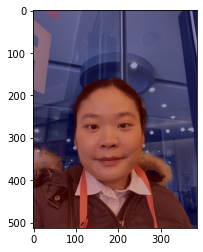

In [11]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

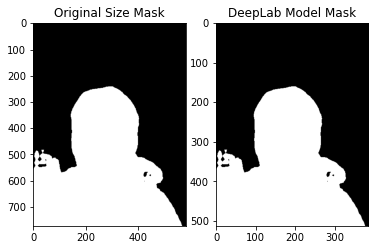

In [12]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

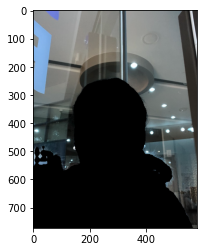

In [13]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

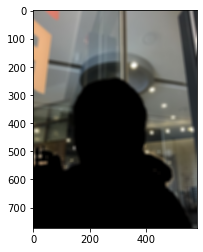

In [14]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

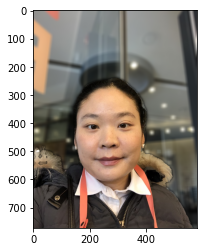

In [15]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

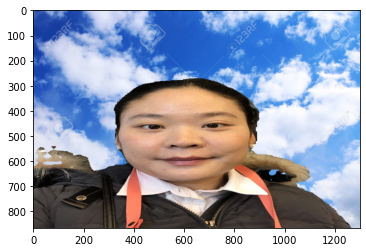

In [16]:
img_resized = cv2.resize(
    img_orig, (bacground_img_orig.shape[1], bacground_img_orig.shape[0]))
img_mask_resized = cv2.resize(
    img_mask_color, (bacground_img_orig.shape[1], bacground_img_orig.shape[0]))

img_background_concat = np.where(
    img_mask_resized == 255, img_resized, bacground_img_orig)

plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

##### Cat

In [17]:
cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)
print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max())

(512, 478, 3) (513, 478, 3) 8


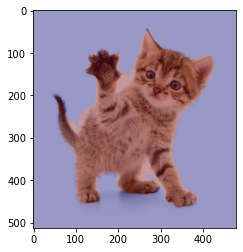

In [18]:
cat_img_show = cat_img_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0)
cat_img_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

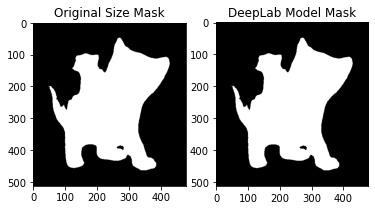

In [19]:
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

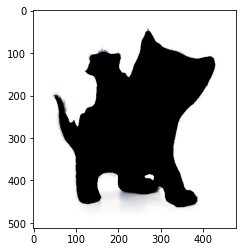

In [20]:
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg = cv2.bitwise_and(cat_img_orig, cat_img_bg_mask)
plt.imshow(cat_img_bg)
plt.show()

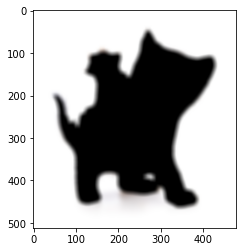

In [21]:
cat_img_bg_blur = cv2.blur(cat_img_bg, (13,13))
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

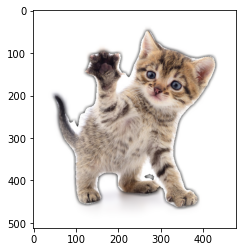

In [22]:
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

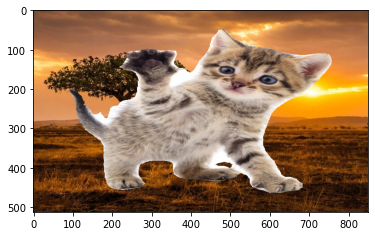

In [23]:
cat_resized = cv2.resize(
    cat_img_orig, (serengeti_img_orig.shape[1], cat_img_orig.shape[0]))
serengeti_img_resized = cv2.resize(
    serengeti_img_orig, (serengeti_img_orig.shape[1], cat_img_orig.shape[0]))
cat_img_mask_resized = cv2.resize(
    cat_img_mask_color, (serengeti_img_orig.shape[1], cat_img_orig.shape[0]))

cat_serengeti_concat = np.where(
    cat_img_mask_resized == 255, cat_resized, serengeti_img_resized)

plt.imshow(cv2.cvtColor(cat_serengeti_concat, cv2.COLOR_BGR2RGB))
plt.show()


### Result

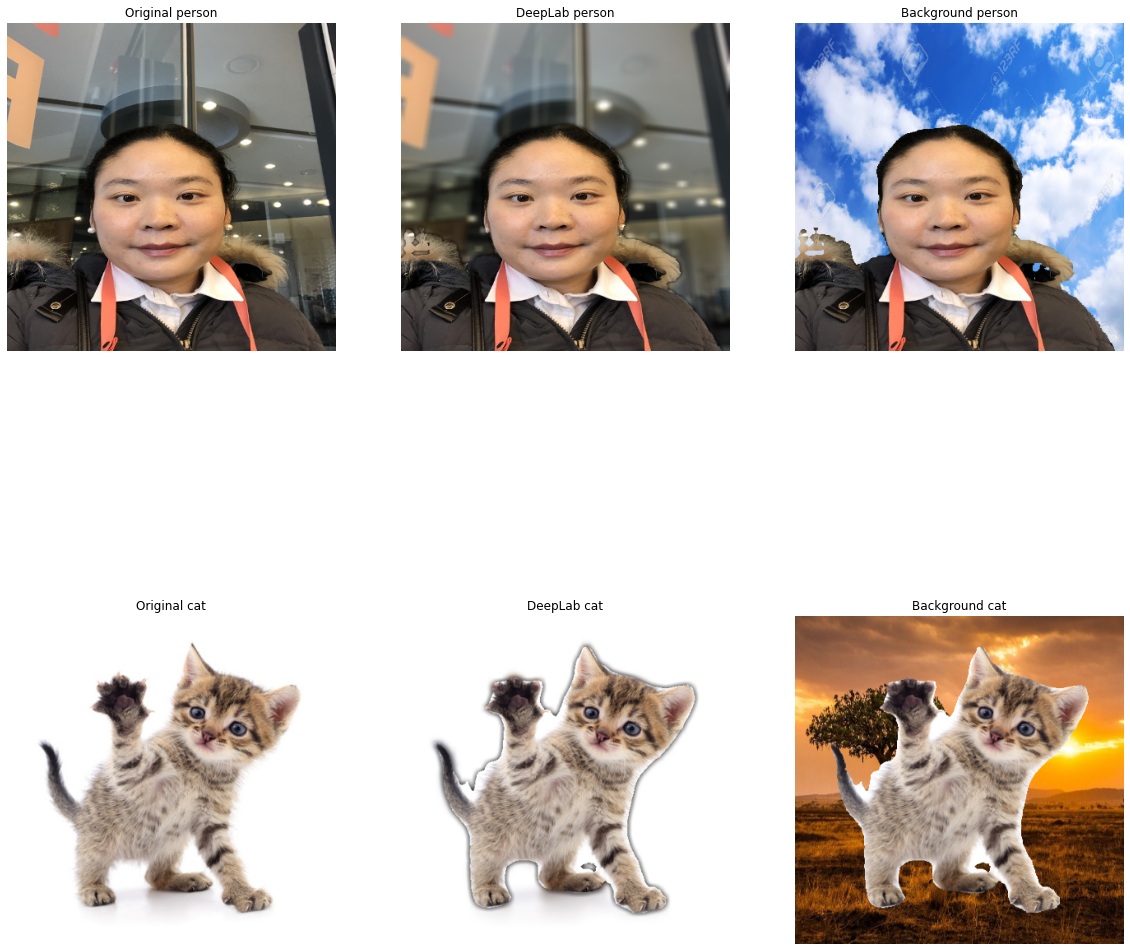

In [24]:
plt.figure(figsize=(20,20))
ax = plt.subplot(2,3,1)
plt.axis('off')
img_orig_resized = cv2.resize(img_orig, (400, 400))
plt.imshow(cv2.cvtColor(img_orig_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Original person')

ax = plt.subplot(2,3,2)
plt.axis('off')
img_concat_resized = cv2.resize(img_concat, (400, 400))
plt.imshow(cv2.cvtColor(img_concat_resized, cv2.COLOR_BGR2RGB))
ax.set_title('DeepLab person')

ax = plt.subplot(2,3,3)
plt.axis('off')
img_background_concat_resized = cv2.resize(img_background_concat, (400, 400))
plt.imshow(cv2.cvtColor(img_background_concat_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Background person')

ax = plt.subplot(2,3,4)
plt.axis('off')
cat_img_orig_resized = cv2.resize(cat_img_orig, (400, 400))
plt.imshow(cv2.cvtColor(cat_img_orig_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Original cat')

ax = plt.subplot(2,3,5)
plt.axis('off')
cat_img_concat_resized = cv2.resize(cat_img_concat, (400, 400))
plt.imshow(cv2.cvtColor(cat_img_concat_resized, cv2.COLOR_BGR2RGB))
ax.set_title('DeepLab cat')

ax = plt.subplot(2,3,6)
plt.axis('off')
cat_serengeti_concat_resized = cv2.resize(cat_serengeti_concat, (400, 400))
plt.imshow(cv2.cvtColor(cat_serengeti_concat_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Background cat')


plt.show()

### Problem
결과물을 보면 object주변에 경계선이 그려지는 것을 볼 수있는데, 굉장히 부자연스러워 보입니다.

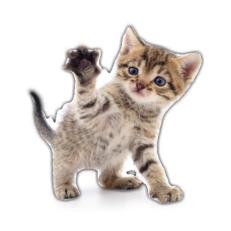

In [26]:
plt.axis('off')
cat_img_concat_resized = cv2.resize(cat_img_concat, (400, 400))
plt.imshow(cv2.cvtColor(cat_img_concat_resized, cv2.COLOR_BGR2RGB))

### Solution
제가 생각해본 해결책은 다음과 같습니다.

    1.semantic segmentaion을 적용하여 원하는 물체를 찾아냅니다.
    2. 찾아낸 부분을 이용하여 마스크1을 만듭니다.
    3. 마스크1 부분의 pixel을 조금씩 이동시켜서 마스크2, 마스크3을 만들어냅니다.
    4. 3개의 마스크를 이용하여 각각 원본과 배경을 concat합니다.
    5. concat으로 만들어지 3개의 영상을 struct2depth 모델을 이용하여 Depth를 계산하고, 원하는 이미지를 얻어냅니다.



### 느낀점(회고)
고양이 사진과 제 사진을 이용하여 아웃포커싱 사진들을 만들어봤습니다. 그리고 크로마키 배경도 합성해보았습니다.